*This notebook was created for writing a blog article on Medium. It's a task that is part of the Udacity's Data Science program. The article can be found [here]().* 

## What you can learn from churn prediction in the automotive service business

### Loading libraries and data

In [36]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
color = 'rebeccapurple'
cmap = 'viridis'

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV, train_test_split, learning_curve
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import make_scorer, fbeta_score, average_precision_score,  roc_curve, roc_auc_score, \
    precision_recall_curve, confusion_matrix, classification_report
from sklearn.externals import joblib

from sklearn.ensemble import GradientBoostingClassifier

# display all columns of df
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 80

In [2]:
churn = pd.read_csv('churnData.csv', low_memory=False)

### EDA

In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49862 entries, 0 to 49861
Data columns (total 43 columns):
target_event               49862 non-null int64
NUM_CONSEC_SERVICES        49862 non-null int64
SUM_INVOICE_AMOUNT         35793 non-null float64
NUM_EVENTS                 49862 non-null int64
LAST_MILEAGE               49861 non-null float64
MEAN_MILEAGE_PER_MNTH      49862 non-null float64
AVG_DIFF_MNTH              49862 non-null int64
age_mnth                   49862 non-null int64
INSPECTION_INTERVAL_UID    49862 non-null object
LIST_PRICE                 49861 non-null float64
END_CUSTOMER_STATUS_UID    49861 non-null object
CAR_BRAND_UID              49862 non-null object
FUEL_TYPE_UID              49861 non-null object
GEAR_TYPE_UID              49861 non-null object
WHEEL_DRIVE_UID            49861 non-null object
NUMBER_OF_DOORS_UID        48854 non-null float64
GEAR_COUNT                 49861 non-null float64
BASE_MARGIN                49862 non-null float64
SALES_T

In [4]:
churn.sample(5)

,target_event,NUM_CONSEC_SERVICES,SUM_INVOICE_AMOUNT,NUM_EVENTS,LAST_MILEAGE,MEAN_MILEAGE_PER_MNTH,AVG_DIFF_MNTH,age_mnth,INSPECTION_INTERVAL_UID,LIST_PRICE,END_CUSTOMER_STATUS_UID,CAR_BRAND_UID,FUEL_TYPE_UID,GEAR_TYPE_UID,WHEEL_DRIVE_UID,NUMBER_OF_DOORS_UID,GEAR_COUNT,BASE_MARGIN,SALES_TYPE,PERSON_LANGUAGE_UID,PERSON_STATE,PERSON_ADRESS_COUNT,ownerAge,REGION_UID,PARTNER_LANGUAGE_UID,IS_PREFERRED_PARTNER,IS_DEALER,PARTNER_STATE,PARTNER_CITY,PARTNER_ADRESS_COUNT,Haushaltstyp,Urbanitaet,Wohneigentumverhaeltnis,Haushaltsgroesse,KaufkraftindexGemeinde,Fahrzeugtyp,Haushaltseinkommen,Fahrzeugklasse,Lebensphase,HaushaltsgroesseFein,Fahrzeugart,dist_metres,duration_days
43270,0,7,6014.25,18,125422.0,1529.536585,4,94,24 Monate,33570.0,03 Privatkunde,SEAT,Benzin,Schaltgetriebe,Frontantrieb,5.0,6.0,8.0,Altea,Französisch,VD,1.0,NaN,Genferseeregion,Französisch,0,1,GE,Châtelaine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38548.0,2505
5871,0,5,3347.70,19,69324.0,1034.686567,3,69,24 Monate,31990.0,52 Privat Kleinflottenfirma,SEAT,Benzin,Schaltgetriebe,Frontantrieb,5.0,6.0,12.0,Leon,Französisch,GE,1.0,32.0,Genferseeregion,Französisch,0,1,GE,Châtelaine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2334.0,2012
3285,1,3,NaN,7,72843.0,1234.627119,8,81,24 Monate,61920.0,26 KMU Privatkunde,Audi,Diesel,Schaltgetriebe,Allradantrieb,5.0,6.0,7.0,A4,Französisch,FR,2.0,40.0,Espace Mittelland,Französisch,0,1,FR,Fribourg,2,2,2,1,1.0,4.0,4,3.0,2,3,1.0,6.0,4606.0,1800
47222,1,5,102.00,18,82316.0,1327.677419,3,84,24 Monate,76535.0,52 Privat Kleinflottenfirma,Audi,Benzin,Schaltgetriebe,Allradantrieb,5.0,6.0,7.0,A4,Deutsch,NW,2.0,43.0,Nordwestschweiz,Deutsch,0,0,AG,Oftringen,2,2,4,,2.0,4.0,0,0.0,0,4,2.0,0.0,71798.0,1881
23338,1,2,NaN,6,89341.0,1823.285714,8,71,24 Monate,33570.0,53 Privat Grossflottenfirma,Audi,Benzin,Schaltgetriebe,Frontantrieb,3.0,6.0,7.0,A1,Italienisch,TI,2.0,30.0,Tessin,Italienisch,0,1,TI,Breganzona,1,2,2,,2.0,6.0,4,4.0,3,0,2.0,6.0,5069.0,1489


In [5]:
print("Number of numerical columns: {}".format(len(churn.select_dtypes(include = ['int64', 'float64']).columns)))
print("Number of categorical columns: {}".format(len(churn.select_dtypes(include = ['object']).columns)))

Number of numerical columns: 24
Number of categorical columns: 19


**Observation:** Many of the numerical columns are categorical in character and should be transformed to categorical variables.

### Fix Datatypes

In [6]:
# transform datatype of numerical columns with categorical character and of object columns
colsToCat = ['CAR_BRAND_UID', 'GEAR_TYPE_UID', 'FUEL_TYPE_UID','WHEEL_DRIVE_UID', 'PERSON_LANGUAGE_UID', 'SALES_TYPE',
            'PARTNER_LANGUAGE_UID', 'ACTIVE', 'IS_PREFERRED_PARTNER', 'IS_DEALER', 'PARTNER_CITY', 'KANTON_LICENCE_PLATE', 
            'BASE_MARGIN', 'GEAR_COUNT', 'PERSON_ADRESS_COUNT', 'NUMBER_OF_DOORS_UID', 'PARTNER_ADRESS_COUNT', 'PARTNER_STATE',
            'INSPECTION_INTERVAL_UID', 'END_CUSTOMER_STATUS_UID', 'PERSON_STATE', 'REGION_UID'] + list(churn.columns[-13:-2])

for col in colsToCat:
    if col in churn.columns:
        churn[col] = churn[col].astype('category')

In [7]:
#check
churn.info()
print("\nNumber of numerical columns: {}".format(len(churn.select_dtypes(include = ['int64', 'float64']).columns)))
print("Number of categorical columns: {}".format(len(churn.select_dtypes(include = ['category']).columns)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49862 entries, 0 to 49861
Data columns (total 43 columns):
target_event               49862 non-null int64
NUM_CONSEC_SERVICES        49862 non-null int64
SUM_INVOICE_AMOUNT         35793 non-null float64
NUM_EVENTS                 49862 non-null int64
LAST_MILEAGE               49861 non-null float64
MEAN_MILEAGE_PER_MNTH      49862 non-null float64
AVG_DIFF_MNTH              49862 non-null int64
age_mnth                   49862 non-null int64
INSPECTION_INTERVAL_UID    49862 non-null category
LIST_PRICE                 49861 non-null float64
END_CUSTOMER_STATUS_UID    49861 non-null category
CAR_BRAND_UID              49862 non-null category
FUEL_TYPE_UID              49861 non-null category
GEAR_TYPE_UID              49861 non-null category
WHEEL_DRIVE_UID            49861 non-null category
NUMBER_OF_DOORS_UID        48854 non-null category
GEAR_COUNT                 49861 non-null category
BASE_MARGIN                49862 non-null c

### Analyze numerical variables and their correlations

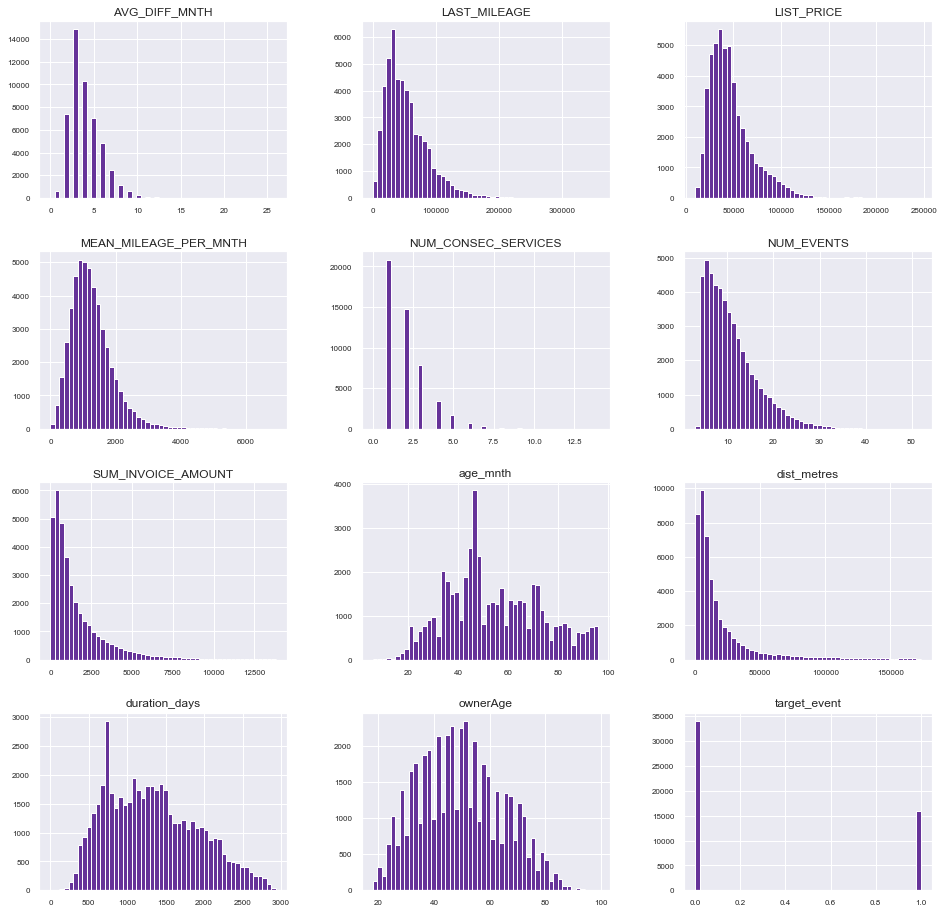

In [8]:
# plot histograms of numerical variables
churn_num = churn.select_dtypes(include = ['float64', 'int64'])    
churn_num.hist(figsize=(16,16), bins=50, xlabelsize=8, ylabelsize=8, color=color);

**Observations:** 
- Most of the data is scewed, and there are some outliers. A tree based model should be able to this.
- The 'binary' column 'target_event' is the _dependent variable_. We can see an imbalance in the two classes, this will have to be considered when splitting into train and test sets.

In [9]:
# print distribution of target labels
tDistr = churn['target_event'].value_counts() / len(churn)
print("ACTIVE in % of total: {:4.2f}".format(tDistr[0]))
print("CHURN in % of total: {:4.2f}".format(tDistr[1]))

ACTIVE in % of total: 0.68
CHURN in % of total: 0.32


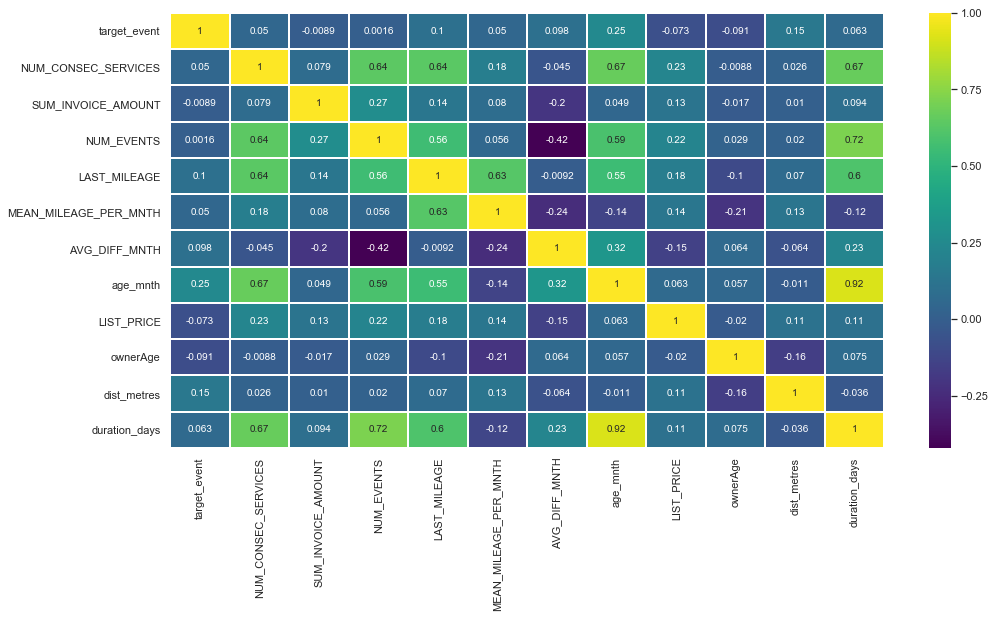

In [10]:
# plot correlation heatmap
plt.figure(figsize=(16,8))
sns.heatmap(churn_num.corr(), cmap=cmap, linecolor='white', linewidth=1, annot=True);

**Observations:** Generally there are no strong correlations in regard to the target variable. Only three variables have a correlation of >= 0.1 (in absolute terms): 
* age_mnth
* dist_metres
* LAST_MILEAGE (highly correlated with age_mnth)
    
There are a few high correlations between the independent variables, but again: a tree based model should be able to handle this.

### Analyze categorical variables and their distributions in regard to the target classes

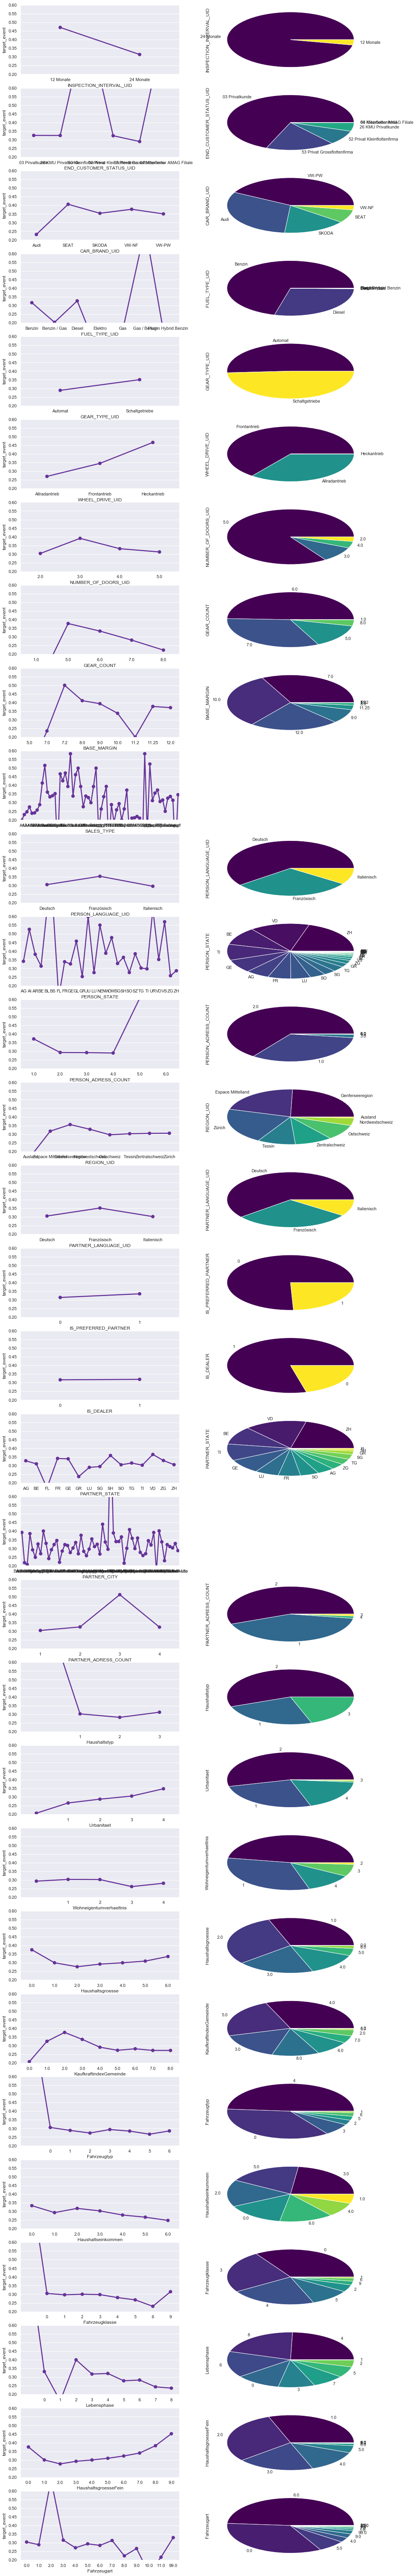

In [11]:
# Create a series of pointplots (and corresponding piecharts) to show correlations between cat columns and target classes
churn_cat = churn.select_dtypes(include = ['category'])
position=0
plt.figure(figsize=(16,120))
for col in churn_cat.columns:
    churn_plot = churn[[col, 'target_event']].groupby(col, as_index=False).mean().sort_values(by='target_event', ascending=False)
    position +=1
    plt.subplot(churn_cat.shape[1],2,position)
    plt.ylim([0.2,0.6])
    sns.pointplot(x=col, y='target_event', data=churn_plot,color=color)
    if churn[col].nunique() <= 30:
        position +=1
        plt.subplot(churn_cat.shape[1],2,position)
        churn[col].value_counts().plot(kind='pie', cmap = cmap)
    else: position +=1

In [12]:
np.mean(churn['target_event'])

0.3188801091011191

**Explanation:** The pointplots show the mean distribution of the target classes for the different categories of a variable (see pies for the distribution of these categories). As there are 32% of CHURN instances in the set a mean of 0.35 indicates that no effect can be seen. Higher means show more CHURN instances as on average, lower means show the contrary. 

**Observations:** These are harder to interpret ... many visually significant differences are due to categories that are very low in count. Nevertheless, the most interesting seem to be: 
* CAR_BRAND_UID: Audi higher than other brands
* GEAR_TYPE_UID --> correlation with brand, age?
* WHEEL_DRIVE_UID --> correlation with brand, age?
* GEAR_COUNT_UID --> correlation with brand, age?
* BASE_MARGIN (7 much higher than 10,12) --> correlation with brand, age?
* PERSON_LANGUAGE_UID / REGION_UID / PARTNER_LANGUAGE_UID (correlated for shure)
* SALES_TYPE?
* PARTNER_CITY? --> one outlier
* PERSON_ADRESS_COUNT?

### Preprocessing for ML: Remove NaN

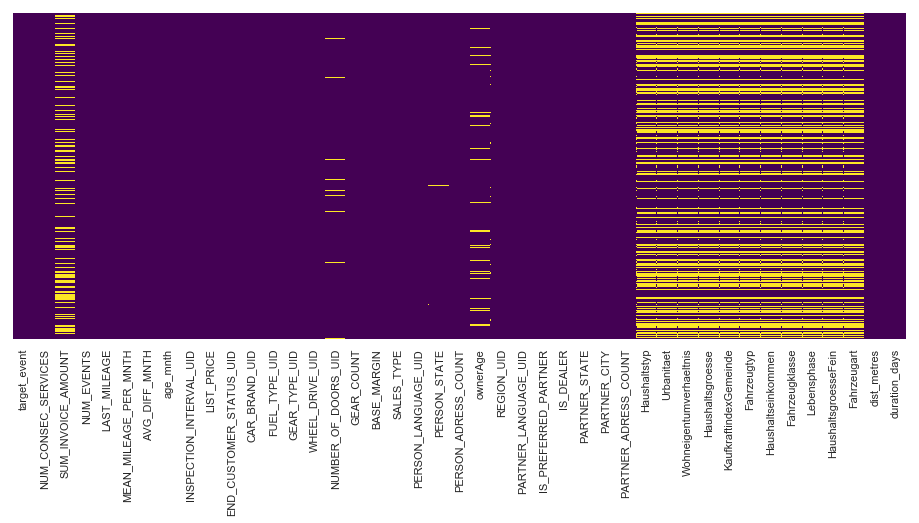

In [13]:
# print overview of missing values
plt.figure(figsize=(16,6))
sns.heatmap(churn.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [14]:
# print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in churn:
    if churn[col].isnull().sum() > 0:
        print(churn[col].name +": "+str(churn[col].isnull().sum()))

Number of NaN per column:
SUM_INVOICE_AMOUNT: 14069
LAST_MILEAGE: 1
LIST_PRICE: 1
END_CUSTOMER_STATUS_UID: 1
FUEL_TYPE_UID: 1
GEAR_TYPE_UID: 1
WHEEL_DRIVE_UID: 1
NUMBER_OF_DOORS_UID: 1008
GEAR_COUNT: 1
PERSON_STATE: 108
ownerAge: 3189
Haushaltstyp: 15963
Urbanitaet: 15963
Wohneigentumverhaeltnis: 15963
Haushaltsgroesse: 15963
KaufkraftindexGemeinde: 15963
Fahrzeugtyp: 15963
Haushaltseinkommen: 15963
Fahrzeugklasse: 15963
Lebensphase: 15963
HaushaltsgroesseFein: 15963
Fahrzeugart: 15964


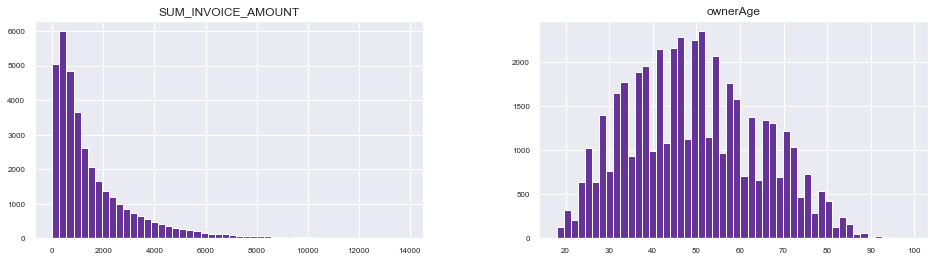

In [15]:
# check numerical columns with NaN
churn[['ownerAge', 'SUM_INVOICE_AMOUNT']].hist(figsize=(16,4), bins=50, xlabelsize=8, ylabelsize=8, color=color);

In [16]:
# remove NaN
colsToImputeNum = ['ownerAge', 'SUM_INVOICE_AMOUNT']
colsToImputeCat = ['NUMBER_OF_DOORS_UID']

# impute median for NaN in specified numerical cols   
for col in colsToImputeNum:
    if col in churn.columns:
        print("{} - median value to impute: {}".format(col, churn[col].median()))
        churn[col].fillna(churn[col].median(), inplace=True)
    else:
        print(col + " not found")
        
# impute mode for NaN in specified categorical cols
for col in colsToImputeCat:
    if col in churn.columns:
        print("{} - most frequent value to impute: {}".format(col, churn[col].value_counts().index[0]))
        churn[col].fillna(churn[col].value_counts().index[0], inplace=True)
    else:
        print(col + " not found")
            
churn.dropna(subset=['LAST_MILEAGE', 'LIST_PRICE', 'FUEL_TYPE_UID'], inplace=True)

#     for col in colsToDrop:
#         if col in churn.columns:
#             churn.drop(col, axis=1, inplace=True)
#         else:
#             display(col + " not found")

ownerAge - median value to impute: 49.0
SUM_INVOICE_AMOUNT - median value to impute: 968.0
NUMBER_OF_DOORS_UID - most frequent value to impute: 5.0


In [17]:
# print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in churn:
    if churn[col].isnull().sum() > 0:
        print(churn[col].name +": "+str(churn[col].isnull().sum()))

Number of NaN per column:
PERSON_STATE: 108
Haushaltstyp: 15962
Urbanitaet: 15962
Wohneigentumverhaeltnis: 15962
Haushaltsgroesse: 15962
KaufkraftindexGemeinde: 15962
Fahrzeugtyp: 15962
Haushaltseinkommen: 15962
Fahrzeugklasse: 15962
Lebensphase: 15962
HaushaltsgroesseFein: 15962
Fahrzeugart: 15963


**Decision:** the remaining NaN will be 'dummied' during one-hot-encoding

### Preprocessing for ML: One-hot-encode the categorical variables

In [18]:
# separate target variable from predictor variables
X = churn.drop('target_event', axis=1)  # note: .drop() creates a copy of the df and does not affect the orgininal
y = churn['target_event'].copy()

In [19]:
# check X-shape
X.shape

(49859, 42)

In [20]:
# for each cat add dummy var, drop original column
X_cat = X.select_dtypes(include='category').columns
for col in  X_cat:
        X = pd.concat([X.drop(col, axis=1), pd.get_dummies(X[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=True)], axis=1)

In [21]:
# check X-shape
X.shape

(49859, 332)

**Observation:** X has now 332 columns (instead of 42 as before).

In [22]:
# print number of NaNs for every column with NaN
print("Number of NaN per column:")
for col in X:
    if X[col].isnull().sum() > 0:
        print(X[col].name +": "+str(X[col].isnull().sum()))

Number of NaN per column:


### Split train and test

In [23]:
# split train and test sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=666, stratify=y)

In [24]:
# safety check distribution of target labels in y_train
print("CHURN in % of total: {:4.2f}".format(np.sum(y_train) / len(y_train)))

CHURN in % of total: 0.32


### Initialize, validate and fit XGBoost

In [25]:
# initalize model
XGB = GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.05, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None,min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=500, n_iter_no_change=None, presort='auto', random_state=None, subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# apply sklearns learning_curve utility on training set with 5-fold CV
N, trainCurve, valCurve = learning_curve(XGB, X_train, y_train, cv=StratifiedKFold(5), 
                                         scoring=make_scorer(fbeta_score, beta=0.5), train_sizes=np.linspace(0.01,1.0,20),
                                         n_jobs=-1, verbose=10)

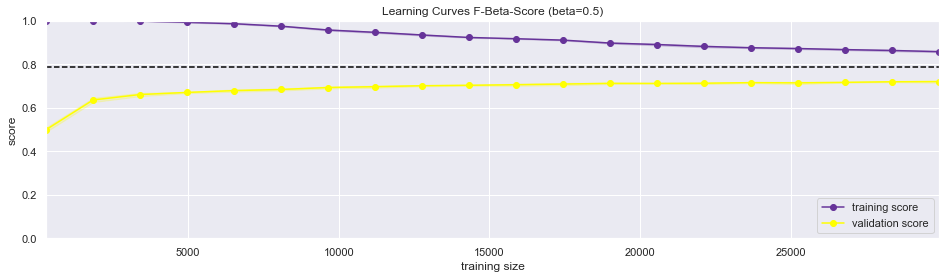

In [30]:
# calculate means and std deviation
trainCurveMean = np.mean(trainCurve, axis=1)
valCurveMean = np.mean(valCurve, axis=1)
trainCurveStd = np.std(trainCurve, axis=1)
valCurveStd = np.std(valCurve, axis=1)
# plot learning curves
plt.figure(figsize=(16,4))
plt.plot(N, trainCurveMean, color='rebeccapurple', marker='o', label='training score')
plt.plot(N, valCurveMean, color='yellow', marker='o', label='validation score')
plt.fill_between(N, trainCurveMean - trainCurveStd,trainCurveMean + trainCurveStd, alpha=0.2, color="rebeccapurple")
plt.fill_between(N, valCurveMean - valCurveStd, valCurveMean + valCurveStd, alpha=0.2, color="yellow")
plt.hlines(np.mean([trainCurveMean[-1], valCurveMean[-1]]), N[0], N[-1], color='black', linestyle='dashed')
# styling
plt.ylim(0,1)
plt.xlim(N[0], N[-1])
plt.xlabel('training size')
plt.ylabel('score')
plt.title("Learning Curves F-Beta-Score (beta=0.5)")
plt.legend(loc='lower right');

In [32]:
# fit model to train data
XGB.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [33]:
# save model to file for later reuse
joblib.dump(XGB, "XGB.joblib.dat") 
print("Saved model to: XGB.joblib.dat")

# # reload model if needed
# XGB = joblib.load("XGB.joblib.dat") 
# print("Loaded model from: XGB.joblib.dat")

Saved model to: XGB.joblib.dat


### Evaluate on test set

In [34]:
# make predictions for test set
predictions = XGB.predict(X_test) 
# evaluate predictions 
fBetaFinal = fbeta_score(y_test, predictions, beta = 0.5) 
print("F-Beta-Score on test data: {:.4f}".format(fBetaFinal))

F-Beta-Score on test data: 0.7307


In [37]:
# print additional metrics
print("Confusion Matrix")
display(confusion_matrix(y_test, predictions))
print("\nClassification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


array([[7670,  820],
       [1423, 2552]], dtype=int64)


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      8490
           1       0.76      0.64      0.69      3975

   micro avg       0.82      0.82      0.82     12465
   macro avg       0.80      0.77      0.78     12465
weighted avg       0.82      0.82      0.82     12465



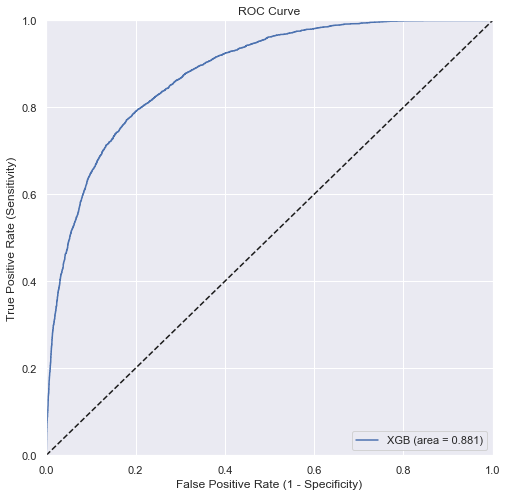

In [42]:
# ROC-curve
# get probabilities of class membership for instances in test set (2nd col is probability for CHURN)
probabilities = XGB.predict_proba(X_test)
# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])
roc_auc = roc_auc_score(y_test, probabilities[:,1])
# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label= "{} (area = {:.3f})".format('XGB', roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
# styling
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=12)
plt.ylabel('True Positive Rate (Sensitivity)', size=12)
plt.title('ROC Curve', size=12)
plt.legend(loc='lower right');

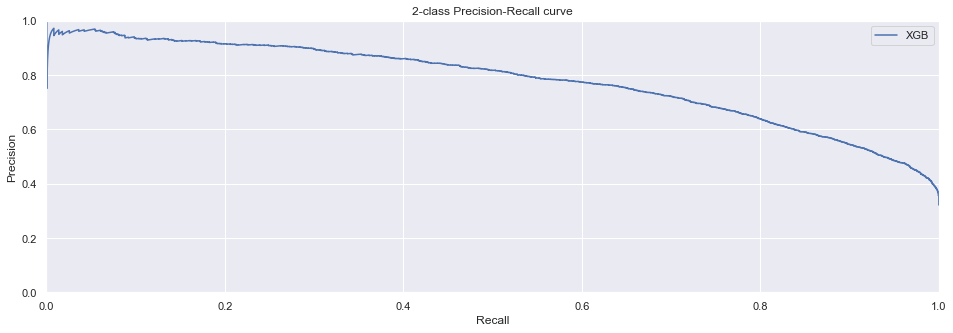

In [44]:
# Precision-Recall-Curve
average_precision = average_precision_score(y_test, probabilities[:,1])
precision, recall, thresholds = precision_recall_curve(y_test, probabilities[:,1])
# plot precision-recall curve
plt.figure(figsize=(16,5))
plt.plot(recall, precision, label='XGB')
# styling
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve'.format( average_precision))
plt.legend(loc='best');